# Mise en correspondance d’images
## Calcul des points d'intêret


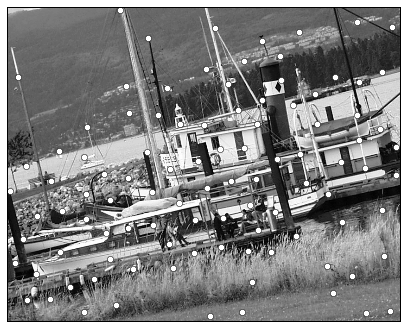

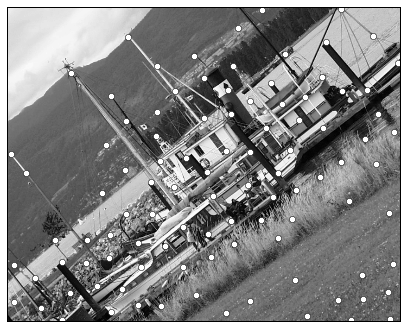

In [150]:
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
%matplotlib inline

def _plot(img, size=2.0):
    plt.subplots_adjust(left=0.0, right=size, bottom=0.0, top=size)
    plt.imshow(img, cmap="gray")
    plt.xticks([])
    plt.yticks([])

def plot_one(img, size=2.0):
    plt.figure()
    plt.subplot(121)
    _plot(img, size)
    
def plot_by_pair(img1, img2):
    plt.figure()
    plt.subplot(121)
    _plot(img1)
    plt.subplot(122)
    _plot(img2)



# goodFeaturesToTrack
def test_goodFeaturesToTrack(img_name):
    img = cv2.imread(img_name)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    points = cv2.goodFeaturesToTrack(gray, 100, 0.1, 50)
    points = [p[0] for p in points]
    
    plot_one(img)
    plt.plot(*zip(*points), marker='o', color='w', ls='')


test_goodFeaturesToTrack("boat/img1.pgm")
test_goodFeaturesToTrack("boat/img2.pgm")

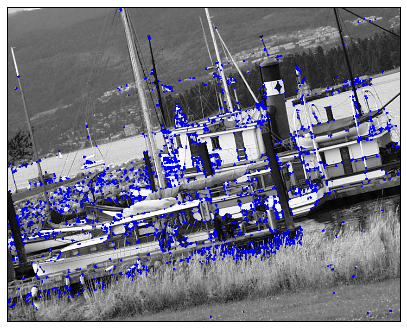

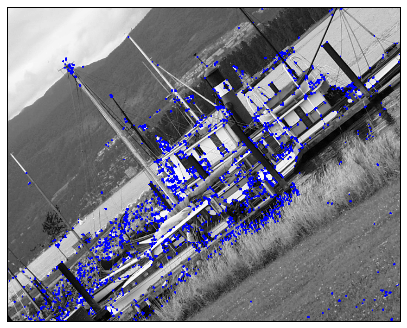

In [151]:
def test_cornerHarris(img_name):
    img = cv2.imread(img_name)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    dst = cv2.cornerHarris(gray,2,3,0.04)

    # result is dilated for marking the corners, not important
    dst = cv2.dilate(dst,None)

    # threshold for an optimal value, it may vary depending on the image.
    img[dst>0.02*dst.max()]=[0,0,255]
    
    plot_one(img)

test_cornerHarris("boat/img1.pgm")
test_cornerHarris("boat/img2.pgm")

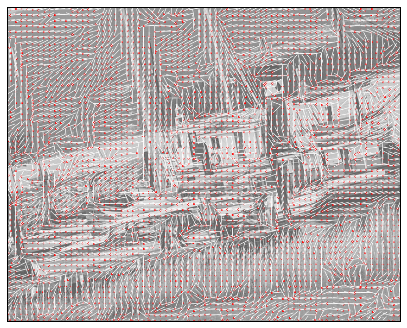

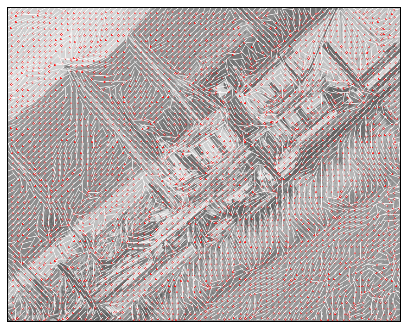

In [152]:
def test_cornerMinEigenVal(img_name):
    img = cv2.imread(img_name)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    h, w = img.shape[:2]
    eigen = cv2.cornerEigenValsAndVecs(gray, 30, 7)
    eigen = eigen.reshape(h, w, 3, 2)  # [[e1, e2], v1, v2]
    flow = eigen[:,:,2]

    vis = img.copy()
    vis[:] = (192 + np.uint32(vis)) / 2
    d = 12
    points =  np.dstack( np.mgrid[d/2:w:d, d/2:h:d] ).reshape(-1, 2)
    for x, y in points:
        vx, vy = np.int32(flow[y, x]*d)
        cv2.circle(vis, (x-vx, y-vy), 2, (255, 0, 0))
        cv2.line(vis, (x-vx, y-vy), (x+vx, y+vy), (255, 255, 255), 1, cv2.CV_AA)

    plot_one(vis)

test_cornerMinEigenVal("boat/img1.pgm")
test_cornerMinEigenVal("boat/img2.pgm")

`goodFeaturesToTrack` semble donner des résultats satisfaisants.

## Calcul de la similarité entre les deux images

0.16357696335
0.279493203192
0.515655310645
0.751813638338
0.791268303306
[ 685.  492.] [ 702.  328.] 0.791268303306
0.792812203039
0.828356820641
0.868744584064
[  94.  170.] [ 315.  317.] 0.868744584064
0.410848019845
1.0
[ 685.  492.] [ 685.  492.] 1.0


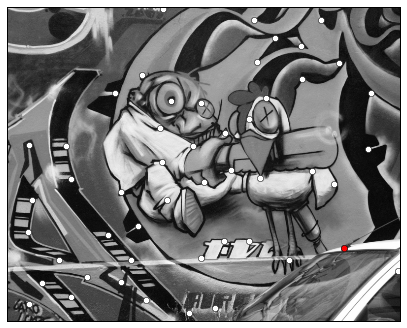

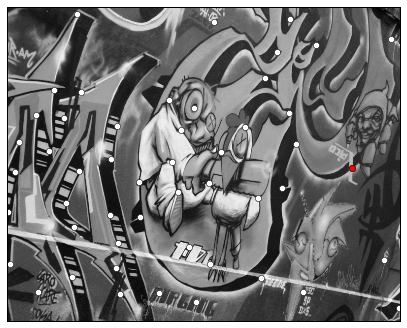

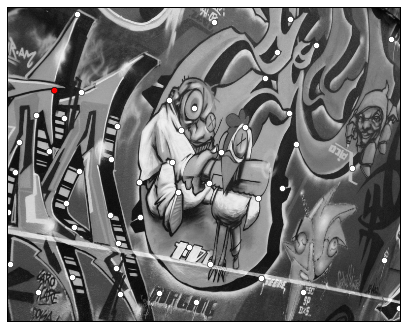

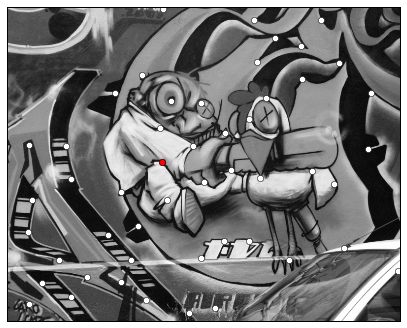

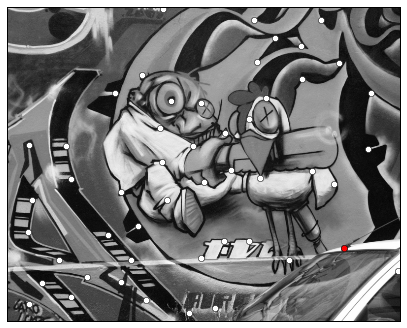

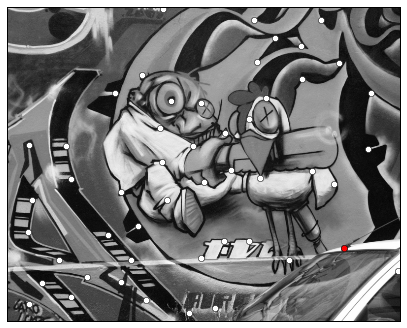

In [156]:
# Taille de la fenêtre
N = 4
P = 4

def sum_pixels_with_func(func, img1, point1, img2, point2):
    s = 0
    u1, v1 = int(point1[0]), int(point1[1])
    u2, v2 = int(point2[0]), int(point2[1])
    
    for i in range(-N, N + 1):
        for j in range(-P, P + 1):
            try:
                pix1 = float(img1[v1 + j, u1 + i])
            except IndexError:
#                 print "warning: out of bounds", u1 + i, v1 + j
                pix1 = 0
            
            try:
                pix2 = float(img2[v2 + j, u2 + i])
            except IndexError:
#                 print "warning: out of bounds", u2 + i, v2 + j
                pix2 = 0

            s += func(pix1, pix2)
    
    return s


def sum_of_absolute_differences(img1, point1, img2, point2):
    absolute = lambda a, b: abs(a - b)
    return sum_pixels_with_func(absolute, img1, point1, img2, point2)


def sum_of_square_differences(img1, point1, img2, point2):
    square = lambda a, b: (a - b)**2
    return sum_pixels_with_func(square, img1, point1, img2, point2)


def zero_mean_sum_of_square_differences(img1, point1, img2, point2):
    mean = lambda a, b: a
    area = (2*N + 1) * (2*P + 1)
    mean1 = 1./area * sum_pixels_with_func(mean, img1, point1, img1, point1)
    mean2 = 1./area * sum_pixels_with_func(mean, img2, point2, img2, point2)

    zssd = lambda a, b: ((a - mean1) - (b - mean2)) ** 2
    return sum_pixels_with_func(zssd, img1, point1, img2, point2)


def zero_mean_normalized_cross_correlation(img1, point1, img2, point2):
    # compute averages
    mean = lambda a, b: a
    area = (2*N + 1) * (2*P + 1)
    mean1 = 1./area * sum_pixels_with_func(mean, img1, point1, img1, point1)
    mean2 = 1./area * sum_pixels_with_func(mean, img2, point2, img2, point2)
    
    # compute std devs
    stdL1 = lambda a, b: (a - mean1) ** 2
    stdL2 = lambda a, b: (a - mean2) ** 2
    std1 = math.sqrt(1./area * sum_pixels_with_func(stdL1, img1, point1, img1, point1))
    std2 = math.sqrt(1./area * sum_pixels_with_func(stdL2, img2, point2, img2, point2))
    
    zncc = lambda a, b: (a - mean1) * (b - mean2)
    return 1./(std1*std2*area) * sum_pixels_with_func(zncc, img1, point1, img2, point2)


def get_points(img):
    points = cv2.goodFeaturesToTrack(img, 50, 0.1, 50)
    return [p[0] for p in points]


def find_best_fit(img1, img2, correlation_func):
    best_fit = None
    best_score = -float("inf")  # /!\ +inf si pas ZMNCC
    
    points1 = get_points(img1)
    points2 = get_points(img2)
    
    for point1 in [points1[1]]:
        for point2 in points2:
            score = correlation_func(img1, point1, img2, point2)
            if score > best_score:  # /!\ pour ZMNCC on veut le max et pas le min! (cos(0) = 1)
                print score
                best_score = score
                best_fit = point2

    print point1, best_fit, best_score
    
    plot_one(img1)
    plt.plot(*zip(*points1), marker='o', color='w', ls='')
    plt.plot(*point1, marker='o', color='r', ls='')

    plot_one(img2)
    plt.plot(*zip(*points2), marker='o', color='w', ls='')
    plt.plot(*best_fit, marker='o', color='r', ls='')

    
img1 = cv2.cvtColor(cv2.imread("graffiti/img1.ppm"), cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(cv2.imread("graffiti/img3.ppm"), cv2.COLOR_BGR2GRAY)

find_best_fit(img1, img2, zero_mean_normalized_cross_correlation)
find_best_fit(img2, img1, zero_mean_normalized_cross_correlation)
find_best_fit(img1, img1, zero_mean_normalized_cross_correlation)

La détection n'est pas très satisfaisante.

***Remarque :*** pour la Zero mean normalized cross-correlation, on cherche le maximum alors que pour les autres on cherche le minimum. Peut-être le rajouter dans le sujet pour les suivants, ça évitera pas mal de temps perdu...

## Comparaison avec SIFT

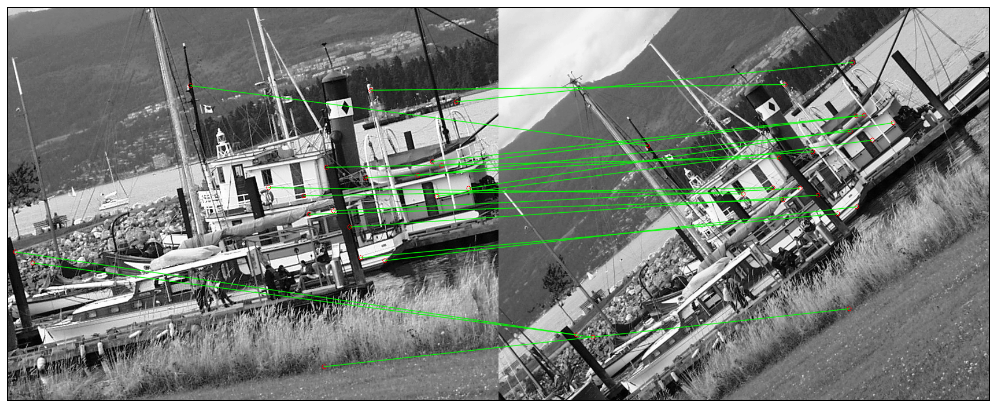

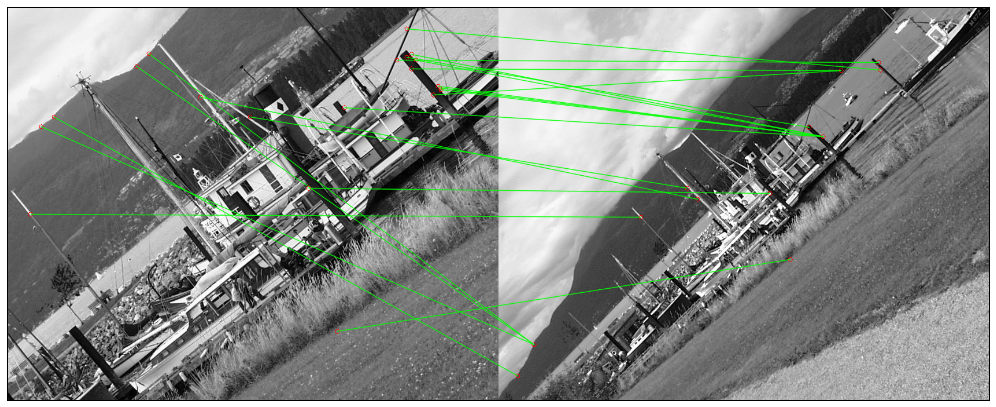

In [154]:
def draw_matches(img1, kp1, img2, kp2, matches):
    """
    Adapté de http://stackoverflow.com/questions/20259025/module-object-has-no-attribute-drawmatches-opencv-python
    """
    # Create a new output image that concatenates the two images together
    rows1, cols1 = img1.shape[:2]
    rows2, cols2 = img2.shape[:2]


    out = np.zeros((max([rows1, rows2]), cols1 + cols2, 3), dtype='uint8')

    # Place the first image to the left
    out[:rows1, :cols1, :] = np.dstack([img1, img1, img1])
    
    # Place the next image to the right of it
    out[:rows2, cols1:cols1 + cols2, :] = np.dstack([img2, img2, img2])

    # For each pair of points we have between both images
    # draw circles, then connect a line between them
    for mat in matches:
        # Get the matching keypoints for each of the images
        img1_idx = mat.queryIdx
        img2_idx = mat.trainIdx

        x1, y1 = kp1[img1_idx].pt
        x2, y2 = kp2[img2_idx].pt

        # Draw a small circle at both co-ordinates
        cv2.circle(out, (int(x1), int(y1)), 4, (255, 0, 0), 1)   
        cv2.circle(out, (int(x2) + cols1, int(y2)), 4, (255, 0, 0), 1)
        
        # Draw a line in between the two points
        cv2.line(out, (int(x1), int(y1)), (int(x2) + cols1, int(y2)), (0, 255, 0), 1, cv2.CV_AA)
    
    plot_one(out, 5)

def test_sift(img1_name, img2_name):
    img1 = cv2.imread(img1_name)
    img2 = cv2.imread(img2_name)

    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    sift = cv2.SIFT()

    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)

    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.75 * n.distance:
            good.append(m)
    good = sorted(good, key=lambda x: x.distance)

    draw_matches(img1, kp1, img2, kp2, good[:20])

test_sift("boat/img1.pgm", "boat/img2.pgm")
test_sift("boat/img2.pgm", "boat/img6.pgm")

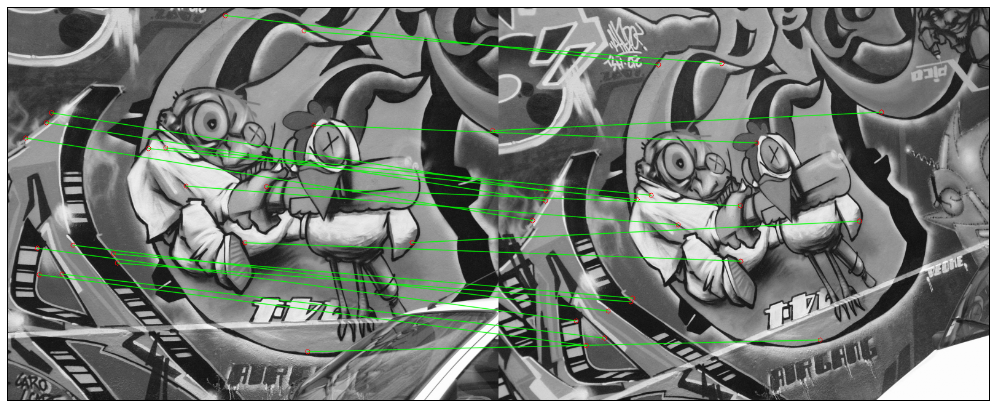

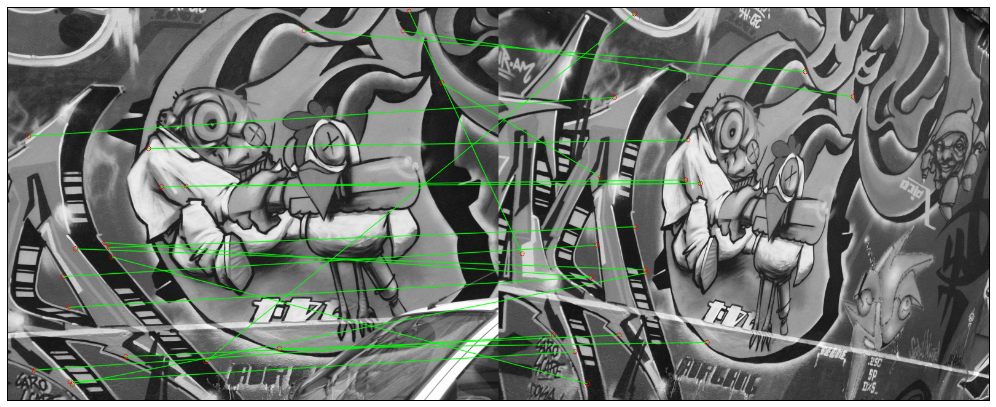

In [155]:
test_sift("graffiti/img1.ppm", "graffiti/img2.ppm")
test_sift("graffiti/img1.ppm", "graffiti/img3.ppm")

La détection est bien meilleure.